# 프로젝트 : Spectrogram Classification 모델 구현

## 1. 데이터 처리와 분류

- 라벨 데이터 처리하기
- `sklearn`의 `Train_test_split` 함수를 이용하여 train, test 분리

In [1]:
import numpy as np
import os
import IPython.display as ipd
import random

In [2]:
import tensorflow as tf

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)
print("✅")

✅


In [3]:
import IPython.display as ipd
import random

# 데이터 선택
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  6518
Wave data shape :  (8000,)
label :  ['no']


#### 데이터를 2차원으로 만들기!!

In [4]:
data = speech_data['wav_vals']

In [5]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [6]:
from tqdm import tqdm

spec_data = []
for one_data in tqdm(data):
    spec = wav2spec(one_data)
    spec_data.append(spec)

spec_data = np.array(spec_data)

100%|██████████| 50620/50620 [00:29<00:00, 1713.28it/s]


In [7]:
print(spec_data.shape)

(50620, 130, 126)


#### 라벨 데이터 만들기!!

In [8]:
# 라벨 데이터 처리
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value
print("✅")

✅


In [9]:
temp = []
for v in speech_data['label_vals']:
    temp.append(label_value[v[0]])

label_data = np.array(temp)

In [10]:
print(label_data.shape)

(50620,)


굳!! 잘 만들어진 것 같습니다. 계속해서 볼까요?!

#### 학습을 위한 데이터 분리

In [11]:
from sklearn.model_selection import train_test_split

train_spec, test_spec, train_label, test_label = train_test_split(spec_data, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)

In [12]:
print("train data : ", train_spec.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_spec.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (45558, 130, 126)
train labels :  (45558,)
test data :  (5062, 130, 126)
test labels :  (5062,)
✅


## 2. 학습을 위한 하이퍼파라미터 설정

#### Hyper parameters setting

In [13]:
batch_size = 16
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'
checkpoint_dir

'/home/aiffel0039/aiffel/speech_recognition/models/wav'

## 3. 데이터셋 구성

- `tf.data.Dataset`을 이용
- `from_tensor_slices` 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용
- map과 batch를 이용한 데이터 전처리

In [14]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


In [15]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
✅


## 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성

- Conv2D layer, batchnorm, dropout, dense layer등을 이용
- 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
- 모델 가중치를 저장하는 checkpoint callback 함수를 추가

In [16]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec = tf.keras.Model(input_tensor, output_tensor)

In [17]:
model_spec.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      2624      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      82976     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        165952    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        331840    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)       

In [18]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [19]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


## 5. 학습 후, 학습이 어떻게 진행되었는지 그래프로 출력

- loss, accuracy를 그래프로 표현

In [ ]:
history_spec = model_spec.fit(
    train_dataset,
    epochs = max_epochs,
    steps_per_epoch = len(train_spec) // batch_size,
    validation_data = test_dataset,
    validation_steps = len(test_spec) // batch_size,
    callbacks = [cp_callback]
)
print("✅")

In [15]:
#30분 내외 소요
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
355/355 [==============================] - ETA: 0s - loss: 1.4667 - accuracy: 0.5123
Epoch 00001: val_loss improved from inf to 1.24444, saving model to /home/aiffel0039/aiffel/speech_recognition/models/wav
355/355 [==============================] - 135s 380ms/step - loss: 1.4667 - accuracy: 0.5123 - val_loss: 1.2444 - val_accuracy: 0.6458
Epoch 2/10
355/355 [==============================] - ETA: 0s - loss: 0.8511 - accuracy: 0.7417
Epoch 00002: val_loss improved from 1.24444 to 0.80731, saving model to /home/aiffel0039/aiffel/speech_recognition/models/wav
355/355 [==============================] - 137s 385ms/step - loss: 0.8511 - accuracy: 0.7417 - val_loss: 0.8073 - val_accuracy: 0.7530
Epoch 3/10
355/355 [==============================] - ETA: 0s - loss: 0.6290 - accuracy: 0.8152
Epoch 00003: val_loss improved from 0.80731 to 0.56948, saving model to /home/aiffel0039/aiffel/speech_recognition/models/wav
355/355 [==============================] - 133s 374ms/step - loss: 0

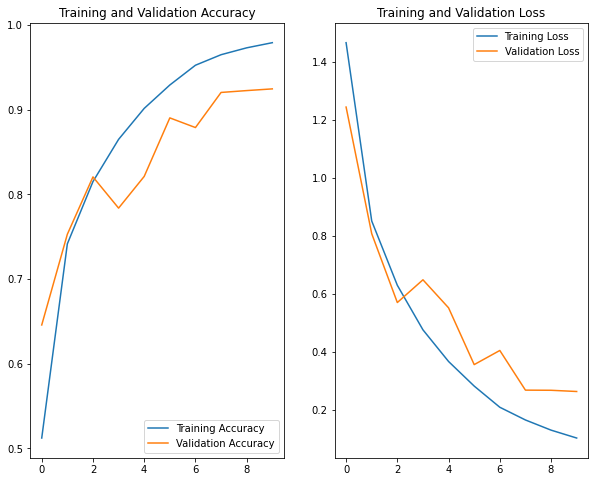

✅


In [17]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [19]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


In [20]:
# 위에서 뽑았던 sample data
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


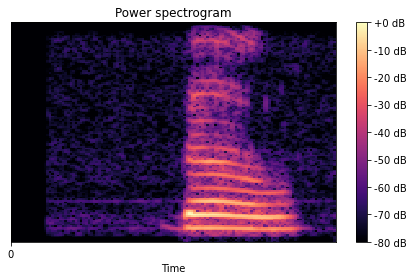

In [21]:
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

In [28]:
spec.shape

(130, 126)

In [43]:
len(label_data)

50620

In [24]:
sr = 8000

train_spec, test_spec, train_label, test_label = train_test_split(
    spec,
    label_data,
    test_size = 0.1,
    shuffle = True
)
print(train_spec)

train_spec = train_spec.reshape([-1, sr, 1]) # add channel for CNN
test_spec = test_spec.reshape([-1, sr, 1])
print("✅")

ValueError: Found input variables with inconsistent numbers of samples: [130, 50620]

In [ ]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])
print("✅")

## 6. Test dataset을 이용해서 모델의 성능을 평가\

- 저장한 weight 불러오기
- 모델의 예측값과 정답값이 얼마나 일치하는지 확인

In [ ]:
model_wav.load_weights(checkpoint_dir)
print("✅")

In [ ]:
results = model_wav.evaluate(test_dataset)
print("✅")

In [ ]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))  Out [22]:
print("✅")

In [ ]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

In [ ]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
print("✅")